# Part 1: Discussion
## result of orginal parameter
1. 學習加法和減法的進度是很像的
2. 同時學會加法和減法一定是比較困難的，因此需要比較多 epoch 才能達到學一個的準確率
3. 只學一種的話其實 epoch 定 100 就很夠了，之後的 100 步進步很少
4. 減法學習的準確率在大部分的時候都比加法高一點點，一開始以為是因為不需要可慮負號所以學的比較好

In [107]:
import matplotlib.pyplot as plt

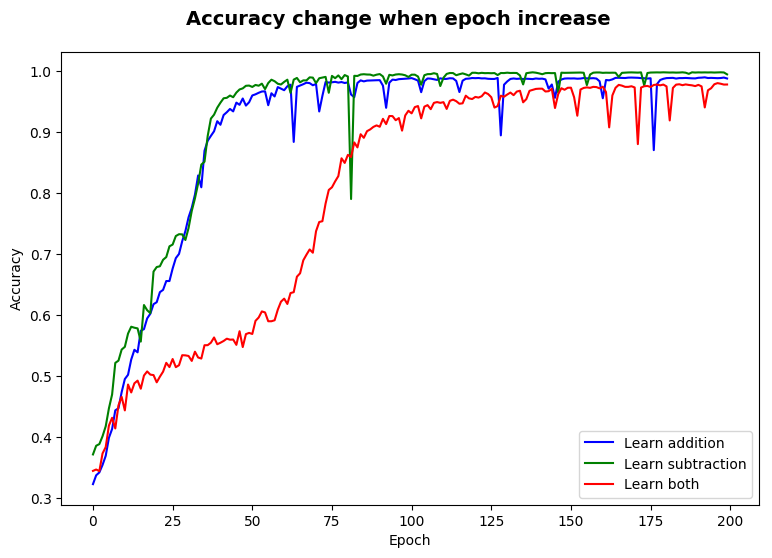

In [169]:
fig = plt.figure(figsize=(9,6),dpi=100)  
fig.suptitle('Accuracy change when epoch increase',y = 0.95, fontsize = 14, fontweight='bold')
ax = fig.add_subplot(1,1,1)
ax.plot(originList, color='b', label='Learn addition')
ax.plot(originList_sub, color='g', label='Learn subtraction')
ax.plot(originList_both, color='r', label='Learn both' )
ax.set_xlabel("Epoch")      
ax.set_ylabel("Accuracy")
ax.legend(loc=4)

## Result when chang the subtraction rule
### 圖例解釋:
1. Learn subtraction v2: 不限制大減小的減法
2. Learn both v2: 學加減法時要考慮減法有負數的結果

### 結果:
- 發現減法範圍到負的數並不會影響學習的效果
- 同時學加減法時要考慮負數竟然表現的比原本的好

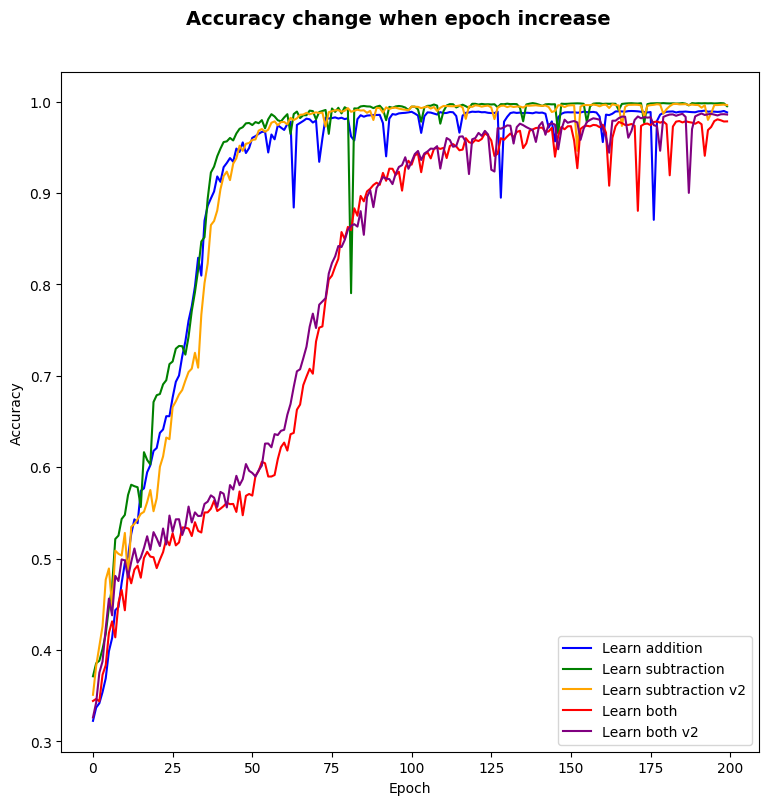

In [168]:
fig = plt.figure(figsize=(9,9),dpi=100)  
fig.suptitle('Accuracy change when epoch increase',y = 0.95, fontsize = 14, fontweight='bold')
ax = fig.add_subplot(1,1,1)
ax.plot(originList, color='b', label='Learn addition')
ax.plot(originList_sub, color='g', label='Learn subtraction')
ax.plot(originList_sub2, color='orange', label='Learn subtraction v2')
ax.plot(originList_both, color='r', label='Learn both' )
ax.plot(originList_both2, color='purple', label='Learn both v2' )
ax.set_xlabel("Epoch")      
ax.set_ylabel("Accuracy")
ax.legend(loc=4)

## result of 7 digit number
- 可以看到用原來的方法來學習7個位數的效果一定比3個入字差，我認為他學習的時候應該是各自學一個數字碰上一個數字、一個入字碰上兩個數字以此類推的學習，所以當數字變多的時候就比較容易學不好，畢竟排列組合變比較多
- 或許每一層 layer 讓他取多一點 feature 可以改善

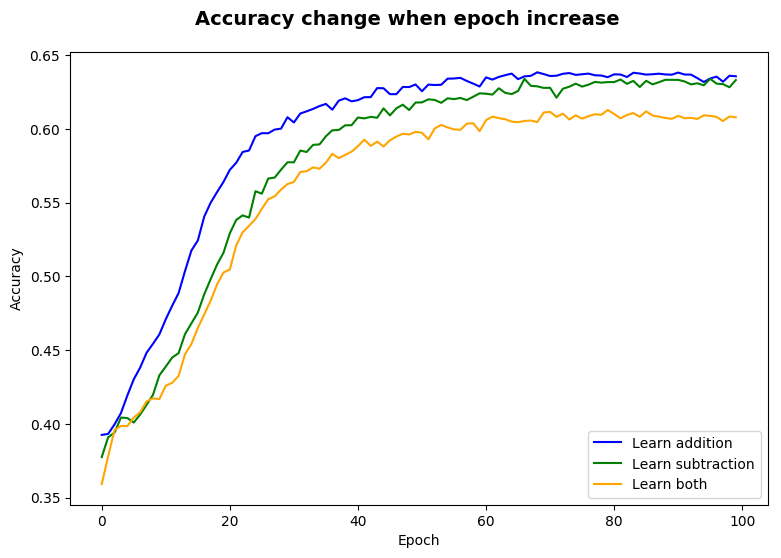

In [166]:
fig = plt.figure(figsize=(9,6),dpi=100)  
fig.suptitle('Accuracy change when epoch increase',y = 0.95, fontsize = 14, fontweight='bold')
ax = fig.add_subplot(1,1,1)
ax.plot(originList7, color='b', label='Learn addition')
ax.plot(originList_sub7, color='g', label='Learn subtraction')
ax.plot(originList_both7, color='orange', label='Learn both')
ax.set_xlabel("Epoch")      
ax.set_ylabel("Accuracy")
ax.legend(loc=4)

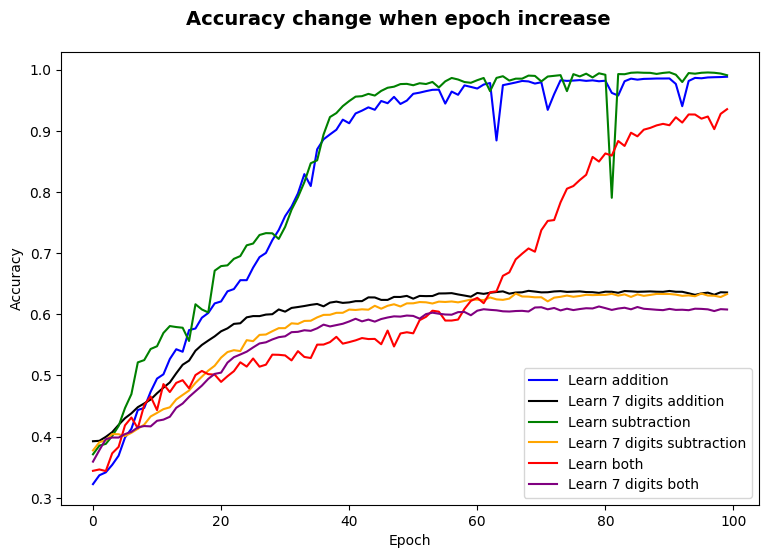

In [167]:
fig = plt.figure(figsize=(9,6),dpi=100)  
fig.suptitle('Accuracy change when epoch increase',y = 0.95, fontsize = 14, fontweight='bold')
ax = fig.add_subplot(1,1,1)
ax.plot(originList[:100], color='b', label='Learn addition')
ax.plot(originList7, color='black', label='Learn 7 digits addition')
ax.plot(originList_sub[:100], color='g', label='Learn subtraction')
ax.plot(originList_sub7, color='orange', label='Learn 7 digits subtraction')
ax.plot(originList_both[:100], color='r', label='Learn both' )
ax.plot(originList_both7, color='purple', label='Learn 7 digits both' )
ax.set_xlabel("Epoch")      
ax.set_ylabel("Accuracy")
ax.legend(loc=4)

# Part 2: Coding

In [1]:
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range

Using TensorFlow backend.


## Addition 
- A + B

### Parameters Config
- Total data size: 80000
- Maximum data: 999
- Minimum data: 0
- Maximum result: 1998
- Minomum result: 0

In [2]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [3]:
TRAINING_SIZE = 80000
DIGITS = 3
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789+ '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

In [4]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows): # ex: (C=43+7, num_rows=MAXLEN) or (C=50, num_rows=DIGITS + 1)
        x = np.zeros((num_rows, len(self.chars))) 
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [5]:
ctable = CharacterTable(chars)

In [9]:
ctable.char_indices

{' ': 0,
 '+': 1,
 '0': 2,
 '1': 3,
 '2': 4,
 '3': 5,
 '4': 6,
 '5': 7,
 '6': 8,
 '7': 9,
 '8': 10,
 '9': 11}

### Data Generation

In [6]:
questions = []
expected = []
seen = set()      # 用來確保資料不會重複
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    # f 是一個產生 1-3 位數亂數的 function
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b)))
    if key in seen: 
        continue
    seen.add(key)
    q = '{}+{}'.format(a, b) # 並沒有說小的數字放前面 大的數字放後面
    query = q + ' ' * (MAXLEN - len(q)) # 確保 input 長度一樣
    ans = str(a + b)
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        query = query[::-1] # [::-1] 會讓 query 相反過來，例如 "43+7   " 變成 "   7+34"，這個寫法我都不知道
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 80000


In [7]:
print(questions[:5], expected[:5])

['368+847', '834+92 ', '69+3   ', '16+82  ', '10+156 '] ['1215', '926 ', '72  ', '98  ', '166 ']


### Processing

In [8]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool) 
y = np.zeros((len(expected), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN) # 取每一筆 sentence 的意思，每一筆 sentence 是用 7 * 12 的矩陣表示
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

Vectorization...


In [9]:
indices = np.arange(len(y))
np.random.shuffle(indices) # 原來把資料弄亂還可以這樣寫
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:20000]    # 20000
train_y = y[:20000]
test_x = x[20000:]     # 60000
test_y = y[20000:]

split_at = len(train_x) - len(train_x) // 10  # split_at=18000
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(18000, 7, 12)
(18000, 4, 12)
Validation Data:
(2000, 7, 12)
(2000, 4, 12)
Testing Data:
(60000, 7, 12)
(60000, 4, 12)


### Build Model

In [50]:
print('Build model...')

############################################
##### Build your own model here ############
############################################
model = Sequential()
# model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars)),return_sequences=True))
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
# model.add(layers.Lambda(lambda x: x[:,-(DIGITS + 1):,:]))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 128)               72192     
_________________________________________________________________
repeat_vector_15 (RepeatVect (None, 4, 128)            0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.save('original_model.h5') 

### Training

In [ ]:
originList = []
for iteration in range(200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    result = model.fit(x_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=1,
                      validation_data=(x_val, y_val))
    originList.append(result.history['val_acc'][0])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)

### Testing

In [53]:
print("MSG : Prediction") 
loss, acc = model.evaluate(test_x,test_y)
print("Loss:",loss)
print("Accuracy:",acc)

MSG : Prediction
60000/60000 [==============================] - 4s 72us/step
Loss: 0.03193951640563707
Accuracy: 0.9897208333333334


In [24]:
model.metrics_names

['loss', 'acc']

## Subtraction version 1 
- (A - B, A ≥ B)

### Parameters Config
- Total data size: 80000
- Maximum data: 999
- Minimum data: 0
- Maximum result: 999
- Minomum result: 0

In [57]:
chars_sub = '0123456789- '

In [58]:
ctable_sub = CharacterTable(chars_sub)

### Data Generation

In [63]:
questions_sub = []
expected_sub = []
seen_sub = set()      
print('Generating data...')
while len(questions_sub) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    a, b = max(a,b),min(a,b)
    key = tuple((a, b))
    if key in seen: 
        continue
    seen.add(key)
    q = '{}-{}'.format(a,b) # 大減小
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a - b)
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        query = query[::-1]
    questions_sub.append(query)
    expected_sub.append(ans)
print('Total addition questions:', len(questions_sub))

Generating data...
Total addition questions: 80000


In [66]:
print(questions_sub[5:10], expected_sub[5:10])

['700-599', '888-879', '501-300', '196-134', '813-698'] ['101 ', '9   ', '201 ', '62  ', '115 ']


### Process

In [67]:
print('Vectorization...')
x = np.zeros((len(questions_sub), MAXLEN, len(chars_sub)), dtype=np.bool) 
y = np.zeros((len(expected_sub), DIGITS + 1, len(chars_sub)), dtype=np.bool)
for i, sentence in enumerate(questions_sub):
    x[i] = ctable_sub.encode(sentence, MAXLEN) 
for i, sentence in enumerate(expected_sub):
    y[i] = ctable_sub.encode(sentence, DIGITS + 1)

Vectorization...


In [68]:
indices = np.arange(len(y))
np.random.shuffle(indices) 
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:20000]    
train_y = y[:20000]
test_x = x[20000:]     
test_y = y[20000:]

split_at = len(train_x) - len(train_x) // 10  # split_at=18000
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(18000, 7, 12)
(18000, 4, 12)
Validation Data:
(2000, 7, 12)
(2000, 4, 12)
Testing Data:
(60000, 7, 12)
(60000, 4, 12)


### Build model

In [70]:
print('Build model...')

model_sub = Sequential()
# model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars)),return_sequences=True))
model_sub.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars_sub))))
model_sub.add(layers.RepeatVector(DIGITS + 1))
# model.add(layers.Lambda(lambda x: x[:,-(DIGITS + 1):,:]))
for _ in range(LAYERS):
    model_sub.add(RNN(HIDDEN_SIZE, return_sequences=True))

model_sub.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model_sub.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model_sub.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 128)               72192     
_________________________________________________________________
repeat_vector_16 (RepeatVect (None, 4, 128)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_13 (TimeDis (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


### training

In [ ]:
originList_sub = []
for iteration in range(200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    result = model_sub.fit(x_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=1,
                      validation_data=(x_val, y_val))
    originList_sub.append(result.history['val_acc'][0])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_sub.predict_classes(rowx, verbose=0)
        q = ctable_sub.decode(rowx[0])
        correct = ctable_sub.decode(rowy[0])
        guess = ctable_sub.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)

In [73]:
model_sub.save('original_model_sub.h5') 

### Testing

In [74]:
print("MSG : Prediction") 
loss, acc = model_sub.evaluate(test_x,test_y)
print("Loss:",loss)
print("Accuracy:",acc)

MSG : Prediction
60000/60000 [==============================] - 4s 74us/step
Loss: 0.02964235748577242
Accuracy: 0.9942666666666666


## Subtraction version 2
- A - B

### Parameters Config
- Total data size: 80000
- Maximum data: 999
- Minimum data: 0
- Maximum result: 999
- Minomum result: -999

In [109]:
questions_sub = []
expected_sub = []
seen_sub = set()      
print('Generating data...')
while len(questions_sub) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple((a, b))
    if key in seen: 
        continue
    seen.add(key)
    q = '{}-{}'.format(a,b) # 不限制大減小
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a - b)
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        query = query[::-1]
    questions_sub.append(query)
    expected_sub.append(ans)
print('Total addition questions:', len(questions_sub))
print(questions_sub[:5],expected_sub[:5])

Generating data...
Total addition questions: 80000
['180-385', '446-928', '172-540', '413-223', '255-438'] ['-205', '-482', '-368', '190 ', '-183']


In [110]:
print('Vectorization...')
x = np.zeros((len(questions_sub), MAXLEN, len(chars_sub)), dtype=np.bool) 
y = np.zeros((len(expected_sub), DIGITS + 1, len(chars_sub)), dtype=np.bool)
for i, sentence in enumerate(questions_sub):
    x[i] = ctable_sub.encode(sentence, MAXLEN) 
for i, sentence in enumerate(expected_sub):
    y[i] = ctable_sub.encode(sentence, DIGITS + 1)

Vectorization...


In [111]:
indices = np.arange(len(y))
np.random.shuffle(indices) 
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:20000]    
train_y = y[:20000]
test_x = x[20000:]     
test_y = y[20000:]

split_at = len(train_x) - len(train_x) // 10  # split_at=18000
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

In [112]:
print('Build model...')

model_sub2 = Sequential()
model_sub2.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars_sub))))
model_sub2.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model_sub2.add(RNN(HIDDEN_SIZE, return_sequences=True))

model_sub2.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model_sub2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model_sub2.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 128)               72192     
_________________________________________________________________
repeat_vector_19 (RepeatVect (None, 4, 128)            0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_16 (TimeDis (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


In [114]:
originList_sub2 = []
for iteration in range(200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    result = model_sub2.fit(x_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=1,
                      validation_data=(x_val, y_val))
    originList_sub2.append(result.history['val_acc'][0])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_sub2.predict_classes(rowx, verbose=0)
        q = ctable_sub.decode(rowx[0])
        correct = ctable_sub.decode(rowy[0])
        guess = ctable_sub.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)


--------------------------------------------------
Iteration 0
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 5s 270us/step - loss: 2.1011 - acc: 0.2869 - val_loss: 1.8419 - val_acc: 0.3509
Q 501-816 T -315 ☒ -10 
Q 899-187 T 712  ☒ -1  
Q 635-482 T 153  ☒ -11 
Q 783-862 T -79  ☒ -11 
Q 991-434 T 557  ☒ 11  
Q 986-766 T 220  ☒ -1  
Q 939-145 T 794  ☒ 11  
Q 404-988 T -584 ☒ -116
Q 238-597 T -359 ☒ -156
Q 368-884 T -516 ☒ -116

--------------------------------------------------
Iteration 1
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 115us/step - loss: 1.7918 - acc: 0.3612 - val_loss: 1.7716 - val_acc: 0.3824
Q 169-958 T -789 ☒ -466
Q 128-617 T -489 ☒ -466
Q 661-615 T 46   ☒ 31  
Q 645-775 T -130 ☒ -10 
Q 811-228 T 583  ☒ 31  
Q 396-674 T -278 ☒ -10 
Q 132-955 T -823 ☒ -466
Q 731-144 T 587  ☒ 31  
Q 977-348 T 629  ☒ 31  
Q 272-563 T -291 ☒ -10 

-------------------

18000/18000 [==============================] - 2s 129us/step - loss: 1.2490 - acc: 0.5400 - val_loss: 1.2337 - val_acc: 0.5430
Q 324-560 T -236 ☒ -222
Q 208-957 T -749 ☒ -702
Q 922-385 T 537  ☒ 554 
Q 372-375 T -3   ☒ -1  
Q 839-196 T 643  ☒ 521 
Q 152-765 T -613 ☒ -612
Q 527-155 T 372  ☒ 311 
Q 175-734 T -559 ☒ -532
Q 622-390 T 232  ☒ 251 
Q 624-740 T -116 ☒ -110

--------------------------------------------------
Iteration 15
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 130us/step - loss: 1.2327 - acc: 0.5453 - val_loss: 1.2199 - val_acc: 0.5489
Q 380-926 T -546 ☒ -532
Q 298-647 T -349 ☒ -392
Q 291-275 T 16   ☒ -1  
Q 512-859 T -347 ☒ -333
Q 887-539 T 348  ☒ 355 
Q 939-145 T 794  ☒ 654 
Q 470-729 T -259 ☒ -272
Q 244-753 T -509 ☒ -507
Q 148-109 T 39   ☒ 11  
Q 943-664 T 279  ☒ 255 

--------------------------------------------------
Iteration 16
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 121us/step - loss: 0.8946 - acc: 0.6880 - val_loss: 0.8977 - val_acc: 0.6844
Q 790-895 T -105 ☒ -101
Q 699-816 T -117 ☒ -110
Q 839-525 T 314  ☒ 315 
Q 619-957 T -338 ☒ -348
Q 254-960 T -706 ☒ -701
Q 959-597 T 362  ☒ 377 
Q 920-941 T -21  ☒ -10 
Q 305-971 T -666 ☒ -669
Q 211-630 T -419 ☒ -418
Q 417-908 T -491 ☒ -482

--------------------------------------------------
Iteration 29
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 123us/step - loss: 0.8711 - acc: 0.6996 - val_loss: 0.8756 - val_acc: 0.6947
Q 508-785 T -277 ☒ -271
Q 403-466 T -63  ☒ -58 
Q 731-816 T -85  ☒ -88 
Q 115-495 T -380 ☒ -372
Q 149-743 T -594 ☒ -592
Q 366-344 T 22   ☒ 11  
Q 348-947 T -599 ☒ -501
Q 398-956 T -558 ☑ -558
Q 290-938 T -648 ☑ -648
Q 175-501 T -326 ☒ -348

--------------------------------------------------
Iteration 30
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 113us/step - loss: 0.3151 - acc: 0.9259 - val_loss: 0.3119 - val_acc: 0.9234
Q 323-884 T -561 ☑ -561
Q 877-313 T 564  ☑ 564 
Q 590-909 T -319 ☒ -328
Q 253-641 T -388 ☑ -388
Q 198-933 T -735 ☒ -734
Q 265-603 T -338 ☒ -348
Q 909-422 T 487  ☑ 487 
Q 639-797 T -158 ☑ -158
Q 347-144 T 203  ☑ 203 
Q 573-869 T -296 ☑ -296

--------------------------------------------------
Iteration 43
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 109us/step - loss: 0.2953 - acc: 0.9302 - val_loss: 0.3138 - val_acc: 0.9141
Q 710-751 T -41  ☑ -41 
Q 232-411 T -179 ☑ -179
Q 107-880 T -773 ☒ -774
Q 356-672 T -316 ☑ -316
Q 568-816 T -248 ☑ -248
Q 355-817 T -462 ☑ -462
Q 600-840 T -240 ☑ -240
Q 396-840 T -444 ☑ -444
Q 846-143 T 703  ☒ 603 
Q 221-555 T -334 ☑ -334

--------------------------------------------------
Iteration 44
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 115us/step - loss: 0.1181 - acc: 0.9787 - val_loss: 0.1298 - val_acc: 0.9769
Q 753-575 T 178  ☑ 178 
Q 419-682 T -263 ☑ -263
Q 564-221 T 343  ☑ 343 
Q 804-860 T -56  ☑ -56 
Q 358-423 T -65  ☑ -65 
Q 939-145 T 794  ☑ 794 
Q 804-860 T -56  ☑ -56 
Q 123-197 T -74  ☑ -74 
Q 951-695 T 256  ☑ 256 
Q 234-297 T -63  ☑ -63 

--------------------------------------------------
Iteration 57
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 113us/step - loss: 0.1094 - acc: 0.9805 - val_loss: 0.1216 - val_acc: 0.9784
Q 284-979 T -695 ☑ -695
Q 202-405 T -203 ☑ -203
Q 777-359 T 418  ☑ 418 
Q 877-683 T 194  ☑ 194 
Q 509-612 T -103 ☑ -103
Q 864-674 T 190  ☑ 190 
Q 749-980 T -231 ☑ -231
Q 521-207 T 314  ☑ 314 
Q 217-265 T -48  ☑ -48 
Q 396-192 T 204  ☑ 204 

--------------------------------------------------
Iteration 58
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 114us/step - loss: 0.0609 - acc: 0.9897 - val_loss: 0.0756 - val_acc: 0.9883
Q 672-801 T -129 ☑ -129
Q 597-603 T -6   ☒ -1  
Q 447-585 T -138 ☑ -138
Q 732-961 T -229 ☑ -229
Q 221-415 T -194 ☑ -194
Q 935-864 T 71   ☑ 71  
Q 792-378 T 414  ☑ 414 
Q 244-802 T -558 ☑ -558
Q 597-938 T -341 ☑ -341
Q 625-402 T 223  ☑ 223 

--------------------------------------------------
Iteration 71
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 114us/step - loss: 0.0590 - acc: 0.9907 - val_loss: 0.0786 - val_acc: 0.9875
Q 301-816 T -515 ☑ -515
Q 995-923 T 72   ☑ 72  
Q 289-573 T -284 ☑ -284
Q 345-671 T -326 ☑ -326
Q 759-545 T 214  ☑ 214 
Q 354-680 T -326 ☑ -326
Q 358-883 T -525 ☑ -525
Q 607-109 T 498  ☑ 498 
Q 268-273 T -5   ☑ -5  
Q 154-313 T -159 ☑ -159

--------------------------------------------------
Iteration 72
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 126us/step - loss: 0.0400 - acc: 0.9933 - val_loss: 0.0604 - val_acc: 0.9903
Q 332-420 T -88  ☑ -88 
Q 542-660 T -118 ☑ -118
Q 847-720 T 127  ☑ 127 
Q 574-335 T 239  ☑ 239 
Q 693-652 T 41   ☑ 41  
Q 224-246 T -22  ☑ -22 
Q 128-617 T -489 ☑ -489
Q 328-928 T -600 ☑ -600
Q 504-596 T -92  ☑ -92 
Q 617-695 T -78  ☑ -78 

--------------------------------------------------
Iteration 85
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 132us/step - loss: 0.0468 - acc: 0.9904 - val_loss: 0.0619 - val_acc: 0.9905
Q 565-147 T 418  ☑ 418 
Q 518-271 T 247  ☑ 247 
Q 248-337 T -89  ☑ -89 
Q 624-740 T -116 ☑ -116
Q 941-848 T 93   ☑ 93  
Q 265-927 T -662 ☑ -662
Q 465-696 T -231 ☑ -231
Q 226-892 T -666 ☑ -666
Q 786-712 T 74   ☑ 74  
Q 157-914 T -757 ☑ -757

--------------------------------------------------
Iteration 86
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 121us/step - loss: 0.0279 - acc: 0.9954 - val_loss: 0.0514 - val_acc: 0.9911
Q 400-812 T -412 ☑ -412
Q 433-823 T -390 ☑ -390
Q 280-509 T -229 ☒ -228
Q 525-331 T 194  ☑ 194 
Q 224-246 T -22  ☑ -22 
Q 682-934 T -252 ☑ -252
Q 298-110 T 188  ☑ 188 
Q 625-597 T 28   ☒ 38  
Q 967-799 T 168  ☑ 168 
Q 328-370 T -42  ☑ -42 

--------------------------------------------------
Iteration 99
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 121us/step - loss: 0.0686 - acc: 0.9802 - val_loss: 0.0531 - val_acc: 0.9906
Q 921-275 T 646  ☑ 646 
Q 834-615 T 219  ☑ 219 
Q 486-184 T 302  ☑ 302 
Q 699-204 T 495  ☑ 495 
Q 486-257 T 229  ☑ 229 
Q 485-882 T -397 ☑ -397
Q 396-674 T -278 ☑ -278
Q 577-823 T -246 ☑ -246
Q 567-557 T 10   ☑ 10  
Q 721-912 T -191 ☑ -191

--------------------------------------------------
Iteration 100
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [====

18000/18000 [==============================] - 2s 121us/step - loss: 0.0172 - acc: 0.9981 - val_loss: 0.0353 - val_acc: 0.9950
Q 164-165 T -1   ☑ -1  
Q 957-926 T 31   ☑ 31  
Q 483-488 T -5   ☑ -5  
Q 990-562 T 428  ☑ 428 
Q 176-134 T 42   ☑ 42  
Q 505-604 T -99  ☑ -99 
Q 827-298 T 529  ☑ 529 
Q 868-940 T -72  ☑ -72 
Q 617-939 T -322 ☑ -322
Q 666-701 T -35  ☑ -35 

--------------------------------------------------
Iteration 113
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 121us/step - loss: 0.0165 - acc: 0.9982 - val_loss: 0.0358 - val_acc: 0.9949
Q 504-851 T -347 ☑ -347
Q 939-523 T 416  ☑ 416 
Q 291-775 T -484 ☑ -484
Q 940-167 T 773  ☑ 773 
Q 529-378 T 151  ☑ 151 
Q 449-583 T -134 ☑ -134
Q 790-548 T 242  ☑ 242 
Q 833-907 T -74  ☑ -74 
Q 231-737 T -506 ☑ -506
Q 155-466 T -311 ☑ -311

--------------------------------------------------
Iteration 114
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 123us/step - loss: 0.0229 - acc: 0.9949 - val_loss: 0.0671 - val_acc: 0.9809
Q 919-829 T 90   ☑ 90  
Q 769-394 T 375  ☑ 375 
Q 755-899 T -144 ☑ -144
Q 149-466 T -317 ☑ -317
Q 608-927 T -319 ☑ -319
Q 893-262 T 631  ☑ 631 
Q 594-361 T 233  ☑ 233 
Q 667-822 T -155 ☑ -155
Q 102-948 T -846 ☑ -846
Q 292-687 T -395 ☑ -395

--------------------------------------------------
Iteration 127
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 125us/step - loss: 0.0601 - acc: 0.9816 - val_loss: 0.0401 - val_acc: 0.9934
Q 726-815 T -89  ☑ -89 
Q 579-393 T 186  ☑ 186 
Q 936-308 T 628  ☑ 628 
Q 622-390 T 232  ☑ 232 
Q 294-683 T -389 ☑ -389
Q 493-636 T -143 ☑ -143
Q 150-364 T -214 ☑ -214
Q 293-328 T -35  ☑ -35 
Q 834-203 T 631  ☑ 631 
Q 907-573 T 334  ☑ 334 

--------------------------------------------------
Iteration 128
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 120us/step - loss: 0.0101 - acc: 0.9992 - val_loss: 0.0296 - val_acc: 0.9955
Q 678-293 T 385  ☑ 385 
Q 361-733 T -372 ☑ -372
Q 185-461 T -276 ☑ -276
Q 254-960 T -706 ☑ -706
Q 789-560 T 229  ☑ 229 
Q 655-362 T 293  ☑ 293 
Q 158-674 T -516 ☑ -516
Q 855-156 T 699  ☑ 699 
Q 604-753 T -149 ☑ -149
Q 350-284 T 66   ☑ 66  

--------------------------------------------------
Iteration 141
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 120us/step - loss: 0.0099 - acc: 0.9992 - val_loss: 0.0286 - val_acc: 0.9954
Q 555-425 T 130  ☑ 130 
Q 377-181 T 196  ☑ 196 
Q 789-560 T 229  ☑ 229 
Q 255-938 T -683 ☑ -683
Q 287-121 T 166  ☑ 166 
Q 366-344 T 22   ☑ 22  
Q 569-177 T 392  ☑ 392 
Q 416-740 T -324 ☑ -324
Q 952-472 T 480  ☑ 480 
Q 249-310 T -61  ☑ -61 

--------------------------------------------------
Iteration 142
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 121us/step - loss: 0.0103 - acc: 0.9992 - val_loss: 0.0271 - val_acc: 0.9962
Q 866-482 T 384  ☑ 384 
Q 827-155 T 672  ☑ 672 
Q 760-421 T 339  ☑ 339 
Q 546-665 T -119 ☑ -119
Q 313-125 T 188  ☑ 188 
Q 240-880 T -640 ☑ -640
Q 838-931 T -93  ☑ -93 
Q 944-449 T 495  ☑ 495 
Q 283-291 T -8   ☑ -8  
Q 612-625 T -13  ☑ -13 

--------------------------------------------------
Iteration 155
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 120us/step - loss: 0.0090 - acc: 0.9995 - val_loss: 0.0264 - val_acc: 0.9962
Q 282-720 T -438 ☑ -438
Q 125-467 T -342 ☑ -342
Q 789-263 T 526  ☑ 526 
Q 684-576 T 108  ☑ 108 
Q 860-509 T 351  ☑ 351 
Q 250-246 T 4    ☑ 4   
Q 399-111 T 288  ☑ 288 
Q 614-871 T -257 ☑ -257
Q 465-554 T -89  ☑ -89 
Q 610-291 T 319  ☑ 319 

--------------------------------------------------
Iteration 156
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 123us/step - loss: 0.0098 - acc: 0.9988 - val_loss: 0.0252 - val_acc: 0.9965
Q 663-759 T -96  ☑ -96 
Q 135-640 T -505 ☑ -505
Q 226-929 T -703 ☑ -703
Q 335-809 T -474 ☑ -474
Q 380-687 T -307 ☑ -307
Q 754-463 T 291  ☑ 291 
Q 942-818 T 124  ☑ 124 
Q 417-908 T -491 ☑ -491
Q 175-501 T -326 ☑ -326
Q 592-306 T 286  ☑ 286 

--------------------------------------------------
Iteration 169
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 121us/step - loss: 0.0074 - acc: 0.9995 - val_loss: 0.0248 - val_acc: 0.9965
Q 473-968 T -495 ☑ -495
Q 687-517 T 170  ☑ 170 
Q 705-444 T 261  ☑ 261 
Q 324-560 T -236 ☑ -236
Q 211-954 T -743 ☑ -743
Q 443-178 T 265  ☑ 265 
Q 478-267 T 211  ☑ 211 
Q 194-190 T 4    ☑ 4   
Q 490-842 T -352 ☑ -352
Q 811-510 T 301  ☑ 301 

--------------------------------------------------
Iteration 170
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 129us/step - loss: 0.0082 - acc: 0.9993 - val_loss: 0.0243 - val_acc: 0.9972
Q 819-978 T -159 ☑ -159
Q 422-303 T 119  ☑ 119 
Q 867-918 T -51  ☑ -51 
Q 760-421 T 339  ☑ 339 
Q 120-829 T -709 ☑ -709
Q 991-162 T 829  ☑ 829 
Q 185-461 T -276 ☑ -276
Q 263-284 T -21  ☑ -21 
Q 612-500 T 112  ☑ 112 
Q 128-736 T -608 ☑ -608

--------------------------------------------------
Iteration 183
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 123us/step - loss: 0.0066 - acc: 0.9996 - val_loss: 0.0236 - val_acc: 0.9976
Q 215-251 T -36  ☑ -36 
Q 269-899 T -630 ☑ -630
Q 725-797 T -72  ☑ -72 
Q 759-545 T 214  ☑ 214 
Q 359-379 T -20  ☑ -20 
Q 269-714 T -445 ☑ -445
Q 562-463 T 99   ☑ 99  
Q 622-125 T 497  ☒ 597 
Q 392-650 T -258 ☑ -258
Q 600-840 T -240 ☑ -240

--------------------------------------------------
Iteration 184
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 123us/step - loss: 0.0061 - acc: 0.9996 - val_loss: 0.0238 - val_acc: 0.9962
Q 129-779 T -650 ☑ -650
Q 977-348 T 629  ☑ 629 
Q 510-958 T -448 ☑ -448
Q 844-919 T -75  ☑ -75 
Q 588-822 T -234 ☑ -234
Q 689-786 T -97  ☑ -97 
Q 647-586 T 61   ☑ 61  
Q 366-610 T -244 ☑ -244
Q 553-804 T -251 ☑ -251
Q 788-917 T -129 ☑ -129

--------------------------------------------------
Iteration 197
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 123us/step - loss: 0.0057 - acc: 0.9997 - val_loss: 0.0237 - val_acc: 0.9965
Q 463-548 T -85  ☑ -85 
Q 890-799 T 91   ☑ 91  
Q 542-698 T -156 ☑ -156
Q 901-113 T 788  ☑ 788 
Q 600-735 T -135 ☑ -135
Q 297-428 T -131 ☑ -131
Q 510-607 T -97  ☑ -97 
Q 967-799 T 168  ☑ 168 
Q 757-926 T -169 ☑ -169
Q 796-999 T -203 ☑ -203

--------------------------------------------------
Iteration 198
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

In [115]:
print("Prediction") 
loss, acc = model_sub2.evaluate(test_x,test_y)
print("Loss:",loss)
print("Accuracy:",acc)

Prediction
60000/60000 [==============================] - 5s 76us/step
Loss: 0.013528052595754464
Accuracy: 0.9973375


In [118]:
AccuracyResult['sub2'] = originList_sub2
AccuracyResult.to_csv('accuracy.csv',index=False)

## Addition & Subtraction v1

In [76]:
chars_both = '0123456789+- '
    
ctable_both = CharacterTable(chars_both)

questions_both = []
expected_both = []
seen_both = set()      
print('Generating data...')
itor = 0
while len(questions_both) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b)))
    if key in seen: 
        continue
    seen.add(key)
    if(itor % 2):
        a, b = max(a,b), min(a,b)
        q = '{}-{}'.format(a, b) 
        query = q + ' ' * (MAXLEN - len(q)) 
        ans = str(a - b)
        ans += ' ' * (DIGITS + 1 - len(ans))
        if REVERSE:
            query = query[::-1] 
        questions_both.append(query)
        expected_both.append(ans)
    else:
        q = '{}+{}'.format(a, b) 
        query = q + ' ' * (MAXLEN - len(q))
        ans = str(a + b)
        ans += ' ' * (DIGITS + 1 - len(ans))
        if REVERSE:
            query = query[::-1] 
        questions_both.append(query)
        expected_both.append(ans)
    itor += 1

Generating data...
Total addition questions: 485640


In [78]:
print(questions_both[:5],expected_both[:5])

['248+626', '962-309', '886+38 ', '878-543', '349+326'] ['874 ', '653 ', '924 ', '335 ', '675 ']


In [79]:
print('Vectorization...')
x = np.zeros((len(questions_both), MAXLEN, len(chars_both)), dtype=np.bool) 
y = np.zeros((len(expected_both), DIGITS + 1, len(chars_both)), dtype=np.bool)
for i, sentence in enumerate(questions_both):
    x[i] = ctable_both.encode(sentence, MAXLEN) 
for i, sentence in enumerate(expected_both):
    y[i] = ctable_both.encode(sentence, DIGITS + 1)

Vectorization...


In [80]:
indices = np.arange(len(y))
np.random.shuffle(indices) 
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:20000]    
train_y = y[:20000]
test_x = x[20000:]     
test_y = y[20000:]

split_at = len(train_x) - len(train_x) // 10  # split_at=18000
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(18000, 7, 13)
(18000, 4, 13)
Validation Data:
(2000, 7, 13)
(2000, 4, 13)
Testing Data:
(60000, 7, 13)
(60000, 4, 13)


In [82]:
print('Build model...')

model_both = Sequential()
model_both.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars_both))))
model_both.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model_both.add(RNN(HIDDEN_SIZE, return_sequences=True))

model_both.add(layers.TimeDistributed(layers.Dense(len(chars_both), activation='softmax')))
model_both.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model_both.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 128)               72704     
_________________________________________________________________
repeat_vector_18 (RepeatVect (None, 4, 128)            0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_15 (TimeDis (None, 4, 13)             1677      
Total params: 205,965
Trainable params: 205,965
Non-trainable params: 0
_________________________________________________________________


In [ ]:
originList_both = []
for iteration in range(200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    result = model_both.fit(x_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=1,
                      validation_data=(x_val, y_val))
    originList_both.append(result.history['val_acc'][0])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_both.predict_classes(rowx, verbose=0)
        q = ctable_both.decode(rowx[0])
        correct = ctable_both.decode(rowy[0])
        guess = ctable_both.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)

In [88]:
model_both.save('original_model_both.h5')

In [89]:
loss, acc = model_both.evaluate(test_x,test_y)

60000/60000 [==============================] - 5s 76us/step


In [90]:
print("Accuracy:",acc)

Accuracy: 0.9773958333333334


## Addition & Subtraction v2

In [119]:
questions_both = []
expected_both = []
seen_both = set()      
print('Generating data...')
itor = 0
while len(questions_both) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b)))
    if key in seen: 
        continue
    seen.add(key)
    if(itor % 2):
        q = '{}-{}'.format(a, b) 
        query = q + ' ' * (MAXLEN - len(q)) 
        ans = str(a - b)
        ans += ' ' * (DIGITS + 1 - len(ans))
        if REVERSE:
            query = query[::-1] 
        questions_both.append(query)
        expected_both.append(ans)
    else:
        q = '{}+{}'.format(a, b) 
        query = q + ' ' * (MAXLEN - len(q))
        ans = str(a + b)
        ans += ' ' * (DIGITS + 1 - len(ans))
        if REVERSE:
            query = query[::-1] 
        questions_both.append(query)
        expected_both.append(ans)
    itor += 1
    
print(questions_both[:5],expected_both[:5])

Generating data...
['665+362', '834-320', '432+155', '382-500', '935+313'] ['1027', '514 ', '587 ', '-118', '1248']


In [121]:
print('Vectorization...')
x = np.zeros((len(questions_both), MAXLEN, len(chars_both)), dtype=np.bool) 
y = np.zeros((len(expected_both), DIGITS + 1, len(chars_both)), dtype=np.bool)
for i, sentence in enumerate(questions_both):
    x[i] = ctable_both.encode(sentence, MAXLEN) 
for i, sentence in enumerate(expected_both):
    y[i] = ctable_both.encode(sentence, DIGITS + 1)

Vectorization...


In [122]:
indices = np.arange(len(y))
np.random.shuffle(indices) 
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:20000]    
train_y = y[:20000]
test_x = x[20000:]     
test_y = y[20000:]

split_at = len(train_x) - len(train_x) // 10  # split_at=18000
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(18000, 7, 13)
(18000, 4, 13)
Validation Data:
(2000, 7, 13)
(2000, 4, 13)
Testing Data:
(60000, 7, 13)
(60000, 4, 13)


In [123]:
print('Build model...')

model_both2 = Sequential()
model_both2.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars_both))))
model_both2.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model_both2.add(RNN(HIDDEN_SIZE, return_sequences=True))

model_both2.add(layers.TimeDistributed(layers.Dense(len(chars_both), activation='softmax')))
model_both2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model_both2.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 128)               72704     
_________________________________________________________________
repeat_vector_20 (RepeatVect (None, 4, 128)            0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_17 (TimeDis (None, 4, 13)             1677      
Total params: 205,965
Trainable params: 205,965
Non-trainable params: 0
_________________________________________________________________


In [124]:
originList_both2 = []
for iteration in range(200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    result = model_both2.fit(x_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=1,
                      validation_data=(x_val, y_val))
    originList_both2.append(result.history['val_acc'][0])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_both2.predict_classes(rowx, verbose=0)
        q = ctable_both.decode(rowx[0])
        correct = ctable_both.decode(rowy[0])
        guess = ctable_both.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)


--------------------------------------------------
Iteration 0
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 5s 287us/step - loss: 2.1829 - acc: 0.2652 - val_loss: 1.9813 - val_acc: 0.3261
Q 532+926 T 1458 ☒ 115 
Q 459-690 T -231 ☒ -35 
Q 716+216 T 932  ☒ 115 
Q 688+124 T 812  ☒ 115 
Q 884+434 T 1318 ☒ 115 
Q 320-728 T -408 ☒ -25 
Q 836-961 T -125 ☒ -15 
Q 209+227 T 436  ☒ 115 
Q 629-908 T -279 ☒ -15 
Q 287-937 T -650 ☒ -35 

--------------------------------------------------
Iteration 1
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 118us/step - loss: 1.9092 - acc: 0.3290 - val_loss: 1.8574 - val_acc: 0.3424
Q 112+931 T 1043 ☒ 110 
Q 579+874 T 1453 ☒ 1110
Q 134-835 T -701 ☒ -244
Q 562-781 T -219 ☒ -11 
Q 727+325 T 1052 ☒ 100 
Q 747-889 T -142 ☒ -21 
Q 562+309 T 871  ☒ 100 
Q 879-977 T -98  ☒ -11 
Q 457+327 T 784  ☒ 100 
Q 557+444 T 1001 ☒ 1400

-------------------

18000/18000 [==============================] - 2s 123us/step - loss: 1.3117 - acc: 0.5162 - val_loss: 1.3279 - val_acc: 0.4955
Q 857+896 T 1753 ☒ 1721
Q 732-460 T 272  ☒ 370 
Q 485+659 T 1144 ☒ 1117
Q 110-270 T -160 ☒ -101
Q 492+579 T 1071 ☒ 1011
Q 808+240 T 1048 ☒ 1077
Q 718-419 T 299  ☒ 370 
Q 603-390 T 213  ☒ 220 
Q 270-423 T -153 ☒ -101
Q 979+591 T 1570 ☒ 1561

--------------------------------------------------
Iteration 15
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 3s 141us/step - loss: 1.3121 - acc: 0.5113 - val_loss: 1.3359 - val_acc: 0.5011
Q 656+271 T 927  ☒ 944 
Q 586+154 T 740  ☒ 741 
Q 532+926 T 1458 ☒ 1417
Q 913+851 T 1764 ☒ 1628
Q 233-517 T -284 ☒ -222
Q 375+252 T 627  ☒ 644 
Q 889-695 T 194  ☒ 178 
Q 478+765 T 1243 ☒ 1214
Q 648-852 T -204 ☒ -133
Q 681+676 T 1357 ☒ 1334

--------------------------------------------------
Iteration 16
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 115us/step - loss: 1.2086 - acc: 0.5507 - val_loss: 1.2423 - val_acc: 0.5257
Q 761+583 T 1344 ☒ 1300
Q 550-771 T -221 ☒ -211
Q 991-141 T 850  ☒ 730 
Q 244-691 T -447 ☒ -411
Q 114+514 T 628  ☒ 655 
Q 797-504 T 293  ☒ 299 
Q 692-827 T -135 ☒ -111
Q 425+674 T 1099 ☒ 1149
Q 327-647 T -320 ☒ -301
Q 871-473 T 398  ☒ 399 

--------------------------------------------------
Iteration 29
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 112us/step - loss: 1.2120 - acc: 0.5499 - val_loss: 1.2427 - val_acc: 0.5355
Q 822-418 T 404  ☒ 400 
Q 473+502 T 975  ☒ 980 
Q 801+288 T 1089 ☒ 1080
Q 746-210 T 536  ☒ 544 
Q 930+405 T 1335 ☒ 1304
Q 980-405 T 575  ☒ 604 
Q 908+696 T 1604 ☒ 1564
Q 603+660 T 1263 ☒ 1244
Q 718-826 T -108 ☒ -10 
Q 798-131 T 667  ☒ 634 

--------------------------------------------------
Iteration 30
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 114us/step - loss: 1.1154 - acc: 0.5851 - val_loss: 1.1674 - val_acc: 0.5559
Q 664-436 T 228  ☒ 221 
Q 346+179 T 525  ☒ 503 
Q 941-857 T 84   ☒ 10  
Q 554+653 T 1207 ☒ 1107
Q 979-390 T 589  ☒ 528 
Q 168-403 T -235 ☒ -237
Q 459-140 T 319  ☒ 332 
Q 613-913 T -300 ☒ -310
Q 673-673 T 0    ☒ -1  
Q 967-879 T 88   ☒ 10  

--------------------------------------------------
Iteration 43
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 111us/step - loss: 1.1127 - acc: 0.5842 - val_loss: 1.1139 - val_acc: 0.5804
Q 675-428 T 247  ☒ 229 
Q 694-819 T -125 ☒ -107
Q 654-215 T 439  ☒ 441 
Q 557+444 T 1001 ☒ 1010
Q 847+173 T 1020 ☒ 1010
Q 562-781 T -219 ☒ -216
Q 840-697 T 143  ☒ 155 
Q 101+820 T 921  ☒ 942 
Q 746-917 T -171 ☒ -156
Q 707-919 T -212 ☒ -210

--------------------------------------------------
Iteration 44
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 116us/step - loss: 0.9558 - acc: 0.6381 - val_loss: 0.9740 - val_acc: 0.6218
Q 494+888 T 1382 ☑ 1382
Q 342-291 T 51   ☑ 51  
Q 921+856 T 1777 ☒ 1787
Q 992+256 T 1248 ☑ 1248
Q 604-274 T 330  ☒ 320 
Q 764+610 T 1374 ☒ 1386
Q 743+298 T 1041 ☑ 1041
Q 596+433 T 1029 ☒ 1020
Q 192+236 T 428  ☒ 402 
Q 564+859 T 1423 ☒ 1422

--------------------------------------------------
Iteration 57
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 111us/step - loss: 0.9285 - acc: 0.6466 - val_loss: 0.9549 - val_acc: 0.6361
Q 466+418 T 884  ☒ 865 
Q 226+459 T 685  ☒ 675 
Q 369-469 T -100 ☑ -100
Q 349-523 T -174 ☒ -155
Q 683+914 T 1597 ☒ 1595
Q 478+931 T 1409 ☑ 1409
Q 709+353 T 1062 ☒ 1031
Q 372-966 T -594 ☒ -503
Q 186+783 T 969  ☒ 977 
Q 430+460 T 890  ☒ 833 

--------------------------------------------------
Iteration 58
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 114us/step - loss: 0.5864 - acc: 0.7871 - val_loss: 0.6376 - val_acc: 0.7522
Q 598+378 T 976  ☑ 976 
Q 828-852 T -24  ☒ -14 
Q 314-455 T -141 ☑ -141
Q 677-746 T -69  ☒ -78 
Q 212+719 T 931  ☒ 930 
Q 168+972 T 1140 ☒ 1130
Q 367-596 T -229 ☒ -239
Q 492+871 T 1363 ☒ 1373
Q 771-767 T 4    ☒ -2  
Q 981+744 T 1725 ☒ 1724

--------------------------------------------------
Iteration 71
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 113us/step - loss: 0.5541 - acc: 0.8041 - val_loss: 0.5918 - val_acc: 0.7777
Q 285+920 T 1205 ☑ 1205
Q 913-702 T 211  ☒ 200 
Q 320+958 T 1278 ☒ 1289
Q 553-880 T -327 ☒ -336
Q 548-241 T 307  ☒ 326 
Q 755-822 T -67  ☒ -56 
Q 466+325 T 791  ☑ 791 
Q 356+629 T 985  ☒ 983 
Q 814+379 T 1193 ☑ 1193
Q 541-568 T -27  ☑ -27 

--------------------------------------------------
Iteration 72
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 125us/step - loss: 0.3113 - acc: 0.9101 - val_loss: 0.3608 - val_acc: 0.8801
Q 115+374 T 489  ☒ 499 
Q 789+877 T 1666 ☑ 1666
Q 325+469 T 794  ☒ 804 
Q 735-315 T 420  ☒ 430 
Q 726+248 T 974  ☒ 964 
Q 133-824 T -691 ☒ -692
Q 646-680 T -34  ☒ -44 
Q 466+325 T 791  ☑ 791 
Q 643-549 T 94   ☒ 15  
Q 618+623 T 1241 ☑ 1241

--------------------------------------------------
Iteration 85
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 119us/step - loss: 0.3188 - acc: 0.9054 - val_loss: 0.4056 - val_acc: 0.8542
Q 344+324 T 668  ☑ 668 
Q 187+227 T 414  ☑ 414 
Q 556+620 T 1176 ☑ 1176
Q 394+932 T 1326 ☑ 1326
Q 367-734 T -367 ☒ -357
Q 541-278 T 263  ☑ 263 
Q 614+796 T 1410 ☒ 1400
Q 369+408 T 777  ☑ 777 
Q 673+202 T 875  ☑ 875 
Q 310+608 T 918  ☑ 918 

--------------------------------------------------
Iteration 86
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 119us/step - loss: 0.1761 - acc: 0.9581 - val_loss: 0.2077 - val_acc: 0.9391
Q 573+165 T 738  ☑ 738 
Q 701+619 T 1320 ☑ 1320
Q 642+582 T 1224 ☑ 1224
Q 389-111 T 278  ☒ 277 
Q 113-929 T -816 ☑ -816
Q 551-210 T 341  ☒ 331 
Q 342-291 T 51   ☒ 43  
Q 424-679 T -255 ☑ -255
Q 396+623 T 1019 ☑ 1019
Q 564+291 T 855  ☑ 855 

--------------------------------------------------
Iteration 99
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 122us/step - loss: 0.1917 - acc: 0.9483 - val_loss: 0.2269 - val_acc: 0.9265
Q 314+608 T 922  ☑ 922 
Q 221-902 T -681 ☒ -692
Q 883+381 T 1264 ☑ 1264
Q 300-857 T -557 ☑ -557
Q 830+999 T 1829 ☑ 1829
Q 341+510 T 851  ☑ 851 
Q 961+312 T 1273 ☑ 1273
Q 186+716 T 902  ☑ 902 
Q 530-751 T -221 ☑ -221
Q 976-444 T 532  ☑ 532 

--------------------------------------------------
Iteration 100
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [====

18000/18000 [==============================] - 2s 131us/step - loss: 0.1070 - acc: 0.9776 - val_loss: 0.1444 - val_acc: 0.9580
Q 130-296 T -166 ☑ -166
Q 668-698 T -30  ☑ -30 
Q 403+665 T 1068 ☑ 1068
Q 285-453 T -168 ☑ -168
Q 769+516 T 1285 ☑ 1285
Q 562-342 T 220  ☒ 210 
Q 126-718 T -592 ☑ -592
Q 970+259 T 1229 ☑ 1229
Q 847-988 T -141 ☑ -141
Q 238-883 T -645 ☑ -645

--------------------------------------------------
Iteration 113
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 117us/step - loss: 0.1032 - acc: 0.9799 - val_loss: 0.1693 - val_acc: 0.9506
Q 665-889 T -224 ☒ -214
Q 712-603 T 109  ☑ 109 
Q 943-317 T 626  ☑ 626 
Q 156-175 T -19  ☑ -19 
Q 281-259 T 22   ☒ 32  
Q 744+727 T 1471 ☑ 1471
Q 176-151 T 25   ☑ 25  
Q 109-354 T -245 ☑ -245
Q 382+960 T 1342 ☑ 1342
Q 443+773 T 1216 ☑ 1216

--------------------------------------------------
Iteration 114
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 129us/step - loss: 0.1194 - acc: 0.9661 - val_loss: 0.2643 - val_acc: 0.9235
Q 381-591 T -210 ☑ -210
Q 992-147 T 845  ☑ 845 
Q 333+778 T 1111 ☑ 1111
Q 842-963 T -121 ☑ -121
Q 641+715 T 1356 ☑ 1356
Q 709+400 T 1109 ☒ 1009
Q 666-924 T -258 ☑ -258
Q 332+846 T 1178 ☑ 1178
Q 924-220 T 704  ☒ 604 
Q 782-293 T 489  ☑ 489 

--------------------------------------------------
Iteration 127
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 126us/step - loss: 0.1303 - acc: 0.9662 - val_loss: 0.1014 - val_acc: 0.9710
Q 575+841 T 1416 ☑ 1416
Q 142+851 T 993  ☑ 993 
Q 248+946 T 1194 ☑ 1194
Q 500-883 T -383 ☑ -383
Q 430+460 T 890  ☑ 890 
Q 527+962 T 1489 ☑ 1489
Q 451+170 T 621  ☑ 621 
Q 116-769 T -653 ☑ -653
Q 466-618 T -152 ☑ -152
Q 153-436 T -283 ☑ -283

--------------------------------------------------
Iteration 128
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 121us/step - loss: 0.0681 - acc: 0.9841 - val_loss: 0.0878 - val_acc: 0.9735
Q 874+487 T 1361 ☑ 1361
Q 447-759 T -312 ☑ -312
Q 857-141 T 716  ☑ 716 
Q 890-354 T 536  ☑ 536 
Q 184-817 T -633 ☒ -643
Q 791-192 T 599  ☒ 699 
Q 626-363 T 263  ☑ 263 
Q 541-568 T -27  ☑ -27 
Q 420-805 T -385 ☑ -385
Q 510+964 T 1474 ☑ 1474

--------------------------------------------------
Iteration 141
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 122us/step - loss: 0.0485 - acc: 0.9921 - val_loss: 0.0783 - val_acc: 0.9776
Q 789+877 T 1666 ☑ 1666
Q 952-752 T 200  ☒ 190 
Q 540-383 T 157  ☑ 157 
Q 986+937 T 1923 ☑ 1923
Q 221-902 T -681 ☑ -681
Q 540+119 T 659  ☑ 659 
Q 683+900 T 1583 ☑ 1583
Q 446-679 T -233 ☑ -233
Q 737+461 T 1198 ☑ 1198
Q 281-259 T 22   ☒ 32  

--------------------------------------------------
Iteration 142
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 125us/step - loss: 0.2207 - acc: 0.9355 - val_loss: 0.0912 - val_acc: 0.9705
Q 617+737 T 1354 ☑ 1354
Q 842-929 T -87  ☑ -87 
Q 810-261 T 549  ☑ 549 
Q 207-723 T -516 ☑ -516
Q 506+812 T 1318 ☑ 1318
Q 389-111 T 278  ☑ 278 
Q 890+102 T 992  ☑ 992 
Q 751-308 T 443  ☑ 443 
Q 404-761 T -357 ☑ -357
Q 112-629 T -517 ☑ -517

--------------------------------------------------
Iteration 155
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 122us/step - loss: 0.0406 - acc: 0.9936 - val_loss: 0.0735 - val_acc: 0.9778
Q 753-282 T 471  ☑ 471 
Q 504+616 T 1120 ☒ 1110
Q 610+161 T 771  ☑ 771 
Q 162+273 T 435  ☑ 435 
Q 440-144 T 296  ☑ 296 
Q 663-903 T -240 ☑ -240
Q 150-141 T 9    ☒ 1   
Q 458-680 T -222 ☑ -222
Q 865-545 T 320  ☒ 310 
Q 445-859 T -414 ☑ -414

--------------------------------------------------
Iteration 156
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 123us/step - loss: 0.0384 - acc: 0.9921 - val_loss: 0.1170 - val_acc: 0.9605
Q 583-877 T -294 ☑ -294
Q 637+301 T 938  ☑ 938 
Q 323-477 T -154 ☑ -154
Q 107+935 T 1042 ☑ 1042
Q 635+267 T 902  ☑ 902 
Q 537-896 T -359 ☑ -359
Q 119-246 T -127 ☑ -127
Q 828+937 T 1765 ☒ 1774
Q 208-726 T -518 ☑ -518
Q 947-597 T 350  ☑ 350 

--------------------------------------------------
Iteration 169
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 122us/step - loss: 0.1351 - acc: 0.9614 - val_loss: 0.0933 - val_acc: 0.9680
Q 913+851 T 1764 ☑ 1764
Q 970-554 T 416  ☑ 416 
Q 553+406 T 959  ☒ 969 
Q 329-280 T 49   ☑ 49  
Q 556-706 T -150 ☑ -150
Q 215+854 T 1069 ☒ 1079
Q 188+567 T 755  ☑ 755 
Q 648-852 T -204 ☑ -204
Q 814-438 T 376  ☑ 376 
Q 892+692 T 1584 ☑ 1584

--------------------------------------------------
Iteration 170
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 120us/step - loss: 0.0191 - acc: 0.9983 - val_loss: 0.0480 - val_acc: 0.9860
Q 982+995 T 1977 ☑ 1977
Q 746+325 T 1071 ☑ 1071
Q 733+579 T 1312 ☑ 1312
Q 387+175 T 562  ☑ 562 
Q 578-520 T 58   ☑ 58  
Q 629+121 T 750  ☑ 750 
Q 349+252 T 601  ☑ 601 
Q 333+393 T 726  ☑ 726 
Q 424-654 T -230 ☑ -230
Q 338-522 T -184 ☑ -184

--------------------------------------------------
Iteration 183
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 121us/step - loss: 0.0186 - acc: 0.9983 - val_loss: 0.0519 - val_acc: 0.9845
Q 335+515 T 850  ☒ 840 
Q 951-737 T 214  ☑ 214 
Q 257-606 T -349 ☑ -349
Q 802+340 T 1142 ☑ 1142
Q 793-901 T -108 ☑ -108
Q 833-374 T 459  ☑ 459 
Q 745+262 T 1007 ☑ 1007
Q 855+765 T 1620 ☑ 1620
Q 643-549 T 94   ☒ 95  
Q 759+296 T 1055 ☑ 1055

--------------------------------------------------
Iteration 184
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 119us/step - loss: 0.0149 - acc: 0.9987 - val_loss: 0.0488 - val_acc: 0.9849
Q 991+809 T 1800 ☒ 1700
Q 762-285 T 477  ☑ 477 
Q 191-874 T -683 ☑ -683
Q 245-876 T -631 ☑ -631
Q 651-380 T 271  ☑ 271 
Q 301-724 T -423 ☑ -423
Q 900-590 T 310  ☒ 300 
Q 620-645 T -25  ☑ -25 
Q 199-525 T -326 ☑ -326
Q 381+459 T 840  ☑ 840 

--------------------------------------------------
Iteration 197
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 118us/step - loss: 0.0149 - acc: 0.9987 - val_loss: 0.0461 - val_acc: 0.9861
Q 126+419 T 545  ☑ 545 
Q 549+537 T 1086 ☑ 1086
Q 961-746 T 215  ☑ 215 
Q 227+664 T 891  ☑ 891 
Q 841-672 T 169  ☑ 169 
Q 199+102 T 301  ☑ 301 
Q 606-760 T -154 ☑ -154
Q 409-758 T -349 ☑ -349
Q 285-998 T -713 ☑ -713
Q 538-246 T 292  ☑ 292 

--------------------------------------------------
Iteration 198
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

In [126]:
print("Prediction") 
loss, acc = model_both2.evaluate(test_x,test_y)
print("Loss:",loss)
print("Accuracy:",acc)

Prediction
60000/60000 [==============================] - 5s 77us/step
Loss: 0.04397998512933651
Accuracy: 0.98635


In [132]:
AccuracyResult['both2'] = originList_both2
AccuracyResult.to_csv('accuracy.csv',index=False)

# 7 digits version

## Addition

In [133]:
TRAINING_SIZE = 80000
DIGITS = 7
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789+ '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

In [134]:
ctable = CharacterTable(chars)

In [135]:
questions = []
expected = []
seen = set()      # 用來確保資料不會重複
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    # f 是一個產生 1-3 位數亂數的 function
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b)))
    if key in seen: 
        continue
    seen.add(key)
    q = '{}+{}'.format(a, b) # 並沒有說小的數字放前面 大的數字放後面
    query = q + ' ' * (MAXLEN - len(q)) # 確保 input 長度一樣
    ans = str(a + b)
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        query = query[::-1] # [::-1] 會讓 query 相反過來，例如 "43+7   " 變成 "   7+34"，這個寫法我都不知道
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 80000


In [137]:
print(questions[:5], expected[:5])

['535+624164     ', '3407540+837813 ', '4616932+0      ', '913556+6562493 ', '7664162+68289  '] ['624699  ', '4245353 ', '4616932 ', '7476049 ', '7732451 ']


In [138]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool) 
y = np.zeros((len(expected), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN) # 取每一筆 sentence 的意思，每一筆 sentence 是用 7 * 12 的矩陣表示
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

Vectorization...


In [139]:
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:20000]    # 20000
train_y = y[:20000]
test_x = x[20000:]     # 60000
test_y = y[20000:]

split_at = len(train_x) - len(train_x) // 10  # split_at=18000
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(18000, 15, 12)
(18000, 8, 12)
Validation Data:
(2000, 15, 12)
(2000, 8, 12)
Testing Data:
(60000, 15, 12)
(60000, 8, 12)


In [140]:
print('Build model...')

############################################
##### Build your own model here ############
############################################
model = Sequential()
# model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars)),return_sequences=True))
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
# model.add(layers.Lambda(lambda x: x[:,-(DIGITS + 1):,:]))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 128)               72192     
_________________________________________________________________
repeat_vector_21 (RepeatVect (None, 8, 128)            0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 8, 128)            131584    
_________________________________________________________________
time_distributed_18 (TimeDis (None, 8, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


In [141]:
originList7 = []
for iteration in range(100):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    result = model.fit(x_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=1,
                      validation_data=(x_val, y_val))
    originList7.append(result.history['val_acc'][0])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)


--------------------------------------------------
Iteration 0
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 7s 406us/step - loss: 1.8300 - acc: 0.3623 - val_loss: 1.7111 - val_acc: 0.3925
Q 7121992+9337363 T 16459355 ☒ 111100  
Q 353+183844      T 184197   ☒ 11100   
Q 8+8867410       T 8867418  ☒ 11000   
Q 4+295926        T 295930   ☒ 1100    
Q 60947+96636     T 157583   ☒ 11100   
Q 7378+6          T 7384     ☒ 130     
Q 7050859+5       T 7050864  ☒ 11000   
Q 4+2736132       T 2736136  ☒ 1100    
Q 923+76          T 999      ☒ 130     
Q 7+8930          T 8937     ☒ 110     

--------------------------------------------------
Iteration 1
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 231us/step - loss: 1.6916 - acc: 0.3906 - val_loss: 1.6740 - val_acc: 0.3932
Q 77+4971513      T 4971590  ☒ 11307   
Q 669640+1933     T 671573   ☒ 113099  
Q 46139+7638      T 

18000/18000 [==============================] - 4s 237us/step - loss: 1.3795 - acc: 0.4750 - val_loss: 1.3582 - val_acc: 0.4801
Q 665384+2        T 665386   ☒ 666673  
Q 2517+651871     T 654388   ☒ 122180  
Q 9947849+5160673 T 15108522 ☒ 90900777
Q 4+144913        T 144917   ☒ 444422  
Q 9767222+59193   T 9826415  ☒ 9977000 
Q 59+717568       T 717627   ☒ 66672   
Q 34+1            T 35       ☒ 10      
Q 37+5648915      T 5648952  ☒ 444482  
Q 218218+449833   T 668051   ☒ 122667  
Q 88652+171321    T 259973   ☒ 103000  

--------------------------------------------------
Iteration 12
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 234us/step - loss: 1.3545 - acc: 0.4836 - val_loss: 1.3335 - val_acc: 0.4886
Q 4924333+699     T 4925032  ☒ 4994474 
Q 3+51408         T 51411    ☒ 51106   
Q 381+3290730     T 3291111  ☒ 3330006 
Q 184+347979      T 348163   ☒ 444926  
Q 5081689+5399    T 5087088  ☒ 5511668 
Q 308725+2        T 30

18000/18000 [==============================] - 4s 247us/step - loss: 1.0915 - acc: 0.5922 - val_loss: 1.1016 - val_acc: 0.5843
Q 5164354+9939    T 5174293  ☒ 5164377 
Q 838699+160157   T 998856   ☒ 100008  
Q 7445514+840681  T 8286195  ☒ 8410938 
Q 6+2985          T 2991     ☒ 2977    
Q 180785+790      T 181575   ☒ 181806  
Q 1879595+633     T 1880228  ☒ 1888005 
Q 450421+62       T 450483   ☒ 440034  
Q 892+34890       T 35782    ☒ 38047   
Q 3+79049         T 79052    ☒ 79043   
Q 6645+3          T 6648     ☒ 6663    

--------------------------------------------------
Iteration 23
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 241us/step - loss: 1.0767 - acc: 0.5972 - val_loss: 1.0978 - val_acc: 0.5853
Q 2054594+80308   T 2134902  ☒ 2530068 
Q 10+83           T 93       ☒ 90      
Q 40021+16043     T 56064    ☒ 11668   
Q 1+3511          T 3512     ☑ 3512    
Q 5291111+5941    T 5297052  ☒ 5211278 
Q 41+94           T 13

18000/18000 [==============================] - 4s 240us/step - loss: 0.9650 - acc: 0.6405 - val_loss: 1.0241 - val_acc: 0.6135
Q 142+107780      T 107922   ☒ 107333  
Q 8611840+3       T 8611843  ☒ 8611219 
Q 84+16324        T 16408    ☒ 16338   
Q 1222+9          T 1231     ☒ 1239    
Q 27+9            T 36       ☒ 42      
Q 160+863753      T 863913   ☒ 863942  
Q 9732810+75      T 9732885  ☒ 9733335 
Q 63350+14        T 63364    ☒ 63343   
Q 7498+371        T 7869     ☒ 8222    
Q 622500+3107325  T 3729825  ☒ 4976690 

--------------------------------------------------
Iteration 34
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 241us/step - loss: 0.9614 - acc: 0.6428 - val_loss: 1.0090 - val_acc: 0.6154
Q 86560+0         T 86560    ☒ 86566   
Q 1135501+5       T 1135506  ☒ 1131105 
Q 4+70530         T 70534    ☒ 70533   
Q 9473+358568     T 368041   ☒ 363342  
Q 11533+44852     T 56385    ☒ 60888   
Q 213092+860      T 21

18000/18000 [==============================] - 4s 238us/step - loss: 0.8918 - acc: 0.6711 - val_loss: 0.9898 - val_acc: 0.6275
Q 747+62771       T 63518    ☒ 63143   
Q 22047+41        T 22088    ☒ 22056   
Q 9633+5          T 9638     ☒ 9635    
Q 73726+7902      T 81628    ☒ 82021   
Q 84995+915       T 85910    ☒ 89767   
Q 5927+4          T 5931     ☒ 5939    
Q 47+228          T 275      ☒ 296     
Q 864788+5791     T 870579   ☒ 868411  
Q 198+4619225     T 4619423  ☒ 4614291 
Q 9620567+6224920 T 15845487 ☒ 10355551

--------------------------------------------------
Iteration 45
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 239us/step - loss: 0.8835 - acc: 0.6734 - val_loss: 0.9983 - val_acc: 0.6235
Q 5262+573835     T 579097   ☒ 579019  
Q 669+622635      T 623304   ☒ 622369  
Q 522+756948      T 757470   ☒ 758085  
Q 5+7909          T 7914     ☒ 7910    
Q 6869160+453338  T 7322498  ☒ 7092220 
Q 973+25          T 99

18000/18000 [==============================] - 4s 230us/step - loss: 0.8298 - acc: 0.6969 - val_loss: 0.9771 - val_acc: 0.6341
Q 2752+301        T 3053     ☒ 3983    
Q 4+57230         T 57234    ☒ 57323   
Q 810+59          T 869      ☒ 876     
Q 5291111+5941    T 5297052  ☒ 5201754 
Q 43+940606       T 940649   ☒ 940600  
Q 508+8342554     T 8343062  ☒ 8342887 
Q 5825797+2708436 T 8534233  ☒ 8022338 
Q 45+2380219      T 2380264  ☒ 2380074 
Q 47+128976       T 129023   ☒ 129786  
Q 142+107780      T 107922   ☒ 107888  

--------------------------------------------------
Iteration 56
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 245us/step - loss: 0.8196 - acc: 0.7002 - val_loss: 0.9914 - val_acc: 0.6346
Q 106+2424        T 2530     ☒ 2488    
Q 9822794+8596654 T 18419448 ☒ 10719999
Q 2395683+54882   T 2450565  ☒ 2333333 
Q 45721+42        T 45763    ☒ 45796   
Q 8975141+24506   T 8999647  ☒ 9876601 
Q 378+6166205     T 61

18000/18000 [==============================] - 4s 231us/step - loss: 0.7685 - acc: 0.7236 - val_loss: 0.9981 - val_acc: 0.6356
Q 236+98488       T 98724    ☒ 98971   
Q 28+1911048      T 1911076  ☒ 1911234 
Q 64989+54        T 65043    ☒ 65001   
Q 24636+42        T 24678    ☒ 24690   
Q 74+11059        T 11133    ☒ 11139   
Q 3+9504          T 9507     ☑ 9507    
Q 564047+8314     T 572361   ☒ 573229  
Q 77+9403702      T 9403779  ☒ 9404501 
Q 720439+69       T 720508   ☒ 720572  
Q 2392+67361      T 69753    ☒ 68713   

--------------------------------------------------
Iteration 67
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 225us/step - loss: 0.7622 - acc: 0.7261 - val_loss: 1.0079 - val_acc: 0.6359
Q 735+2           T 737      ☒ 736     
Q 23264+9         T 23273    ☒ 23264   
Q 576+381         T 957      ☒ 900     
Q 604541+71059    T 675600   ☒ 673640  
Q 103+75          T 178      ☒ 185     
Q 24+6913016      T 69

18000/18000 [==============================] - 4s 233us/step - loss: 0.7128 - acc: 0.7461 - val_loss: 1.0317 - val_acc: 0.6363
Q 4734+4          T 4738     ☒ 4749    
Q 690843+10755    T 701598   ☒ 791100  
Q 86+5725050      T 5725136  ☒ 5725132 
Q 634326+700      T 635026   ☒ 635215  
Q 7271+979        T 8250     ☒ 8011    
Q 47+11           T 58       ☒ 59      
Q 9511+60         T 9571     ☒ 9564    
Q 37763+66811     T 104574   ☒ 100826  
Q 2+3423          T 3425     ☒ 3444    
Q 9+1869450       T 1869459  ☒ 1869455 

--------------------------------------------------
Iteration 78
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 241us/step - loss: 0.7011 - acc: 0.7522 - val_loss: 1.0408 - val_acc: 0.6361
Q 47873+67920     T 115793   ☒ 111026  
Q 61+401920       T 401981   ☒ 401038  
Q 552666+71       T 552737   ☒ 552641  
Q 626+59          T 685      ☒ 688     
Q 4+637591        T 637595   ☒ 637591  
Q 9094660+98      T 90

18000/18000 [==============================] - 4s 236us/step - loss: 0.6503 - acc: 0.7715 - val_loss: 1.0919 - val_acc: 0.6369
Q 8200582+165045  T 8365627  ☒ 8221622 
Q 69847+9         T 69856    ☒ 69881   
Q 207326+74160    T 281486   ☒ 277888  
Q 39416+3         T 39419    ☑ 39419   
Q 46051+897804    T 943855   ☒ 130918  
Q 2+9541187       T 9541189  ☒ 9541300 
Q 2213+402        T 2615     ☒ 2516    
Q 530511+7490     T 538001   ☒ 531075  
Q 2469938+4       T 2469942  ☒ 2469841 
Q 15+826610       T 826625   ☒ 826615  

--------------------------------------------------
Iteration 89
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 224us/step - loss: 0.6431 - acc: 0.7755 - val_loss: 1.0983 - val_acc: 0.6367
Q 76+4300         T 4376     ☒ 4379    
Q 148+0           T 148      ☑ 148     
Q 341+4618948     T 4619289  ☒ 4619021 
Q 1209077+6755810 T 7964887  ☒ 9811144 
Q 24+6068         T 6092     ☒ 6115    
Q 36+475670       T 47

18000/18000 [==============================] - 4s 224us/step - loss: 0.5929 - acc: 0.7947 - val_loss: 1.1479 - val_acc: 0.6356
Q 6160519+817778  T 6978297  ☒ 7403733 
Q 840+7939823     T 7940663  ☒ 7931372 
Q 6549498+2457789 T 9007287  ☒ 679924  
Q 892+34890       T 35782    ☒ 49787   
Q 40831+115665    T 156496   ☒ 195325  
Q 6602+687745     T 694347   ☒ 785445  
Q 6+20            T 26       ☒ 28      
Q 944+99170       T 100114   ☒ 10026   
Q 48424+296923    T 345347   ☒ 348636  
Q 596+249611      T 250207   ☒ 259180  


## Subtraction

In [143]:
chars = '0123456789- '

In [144]:
ctable = CharacterTable(chars)

In [145]:
questions = []
expected = []
seen = set()      
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b)))
    if key in seen: 
        continue
    seen.add(key)
    q = '{}-{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q)) 
    ans = str(a - b)
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        query = query[::-1] 
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 80000


In [146]:
print(questions[:5],expected[:5])

['6-8            ', '24975-9501728  ', '78-65031       ', '7-9            ', '6798-9283      '] ['-2      ', '-9476753', '-64953  ', '-2      ', '-2485   ']


In [147]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool) 
y = np.zeros((len(expected), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN) # 取每一筆 sentence 的意思，每一筆 sentence 是用 7 * 12 的矩陣表示
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

Vectorization...


In [148]:
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:20000]    # 20000
train_y = y[:20000]
test_x = x[20000:]     # 60000
test_y = y[20000:]

split_at = len(train_x) - len(train_x) // 10  # split_at=18000
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

In [149]:
print('Build model...')

############################################
##### Build your own model here ############
############################################
model = Sequential()
# model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars)),return_sequences=True))
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
# model.add(layers.Lambda(lambda x: x[:,-(DIGITS + 1):,:]))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 128)               72192     
_________________________________________________________________
repeat_vector_22 (RepeatVect (None, 8, 128)            0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 8, 128)            131584    
_________________________________________________________________
time_distributed_19 (TimeDis (None, 8, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


In [150]:
originList_sub7 = []
for iteration in range(100):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    result = model.fit(x_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=1,
                      validation_data=(x_val, y_val))
    originList_sub7.append(result.history['val_acc'][0])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)


--------------------------------------------------
Iteration 0
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 8s 420us/step - loss: 1.9661 - acc: 0.3243 - val_loss: 1.8030 - val_acc: 0.3774
Q 43-5701178      T -5701135 ☒ -23339  
Q 5689-69847      T -64158   ☒ -2333   
Q 7-972           T -965     ☒ -53     
Q 72049-77922     T -5873    ☒ -23339  
Q 3040-1797       T 1243     ☒ -2339   
Q 53-4569         T -4516    ☒ -233    
Q 52924-7         T 52917    ☒ -233    
Q 9391-45492      T -36101   ☒ -2333   
Q 66515-623       T 65892    ☒ -2339   
Q 5663-8209       T -2546    ☒ -2339   

--------------------------------------------------
Iteration 1
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 227us/step - loss: 1.7276 - acc: 0.3871 - val_loss: 1.6788 - val_acc: 0.3909
Q 1-657592        T -657591  ☒ -14442  
Q 71132-8         T 71124    ☒ 266     
Q 43168-7         T 

18000/18000 [==============================] - 4s 235us/step - loss: 1.4645 - acc: 0.4474 - val_loss: 1.4643 - val_acc: 0.4449
Q 9286462-374219  T 8912243  ☒ 8999111 
Q 5-9734138       T -9734133 ☒ -9989991
Q 3462-3156       T 306      ☒ 2339    
Q 97-693          T -596     ☒ -800    
Q 87530-56339     T 31191    ☒ 57099   
Q 92917-79365     T 13552    ☒ -3091   
Q 12594-80060     T -67466   ☒ -10999  
Q 87418-62        T 87356    ☒ 87774   
Q 7632-95751      T -88119   ☒ -60091  
Q 0-35741         T -35741   ☒ -44331  

--------------------------------------------------
Iteration 12
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 236us/step - loss: 1.4421 - acc: 0.4543 - val_loss: 1.4559 - val_acc: 0.4479
Q 301501-5786     T 295715   ☒ 100000  
Q 476-90          T 386      ☒ 780     
Q 5-8705          T -8700    ☒ -8680   
Q 908-564256      T -563348  ☒ -900120 
Q 16049-2331      T 13718    ☒ 10000   
Q 8000599-892545  T 71

18000/18000 [==============================] - 4s 231us/step - loss: 1.1989 - acc: 0.5515 - val_loss: 1.2064 - val_acc: 0.5413
Q 5113-75         T 5038     ☒ 5008    
Q 3096-8961       T -5865    ☒ -5040   
Q 69-863958       T -863889  ☒ -965344 
Q 3329-59941      T -56612   ☒ -52776  
Q 42629-35233     T 7396     ☒ -188    
Q 6855108-756841  T 6098267  ☒ 5544376 
Q 761-532790      T -532029  ☒ -544339 
Q 289403-589      T 288814   ☒ 288833  
Q 8561076-7       T 8561069  ☒ 8555469 
Q 903-86          T 817      ☒ 802     

--------------------------------------------------
Iteration 23
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 234us/step - loss: 1.1770 - acc: 0.5599 - val_loss: 1.2095 - val_acc: 0.5398
Q 8656212-8       T 8656204  ☒ 8555566 
Q 17533-87850     T -70317   ☒ -73002  
Q 6666572-31      T 6666541  ☒ 6666666 
Q 18-4            T 14       ☒ 11      
Q 555-1243        T -688     ☒ -198    
Q 7960995-4       T 79

18000/18000 [==============================] - 4s 231us/step - loss: 1.0477 - acc: 0.6077 - val_loss: 1.0897 - val_acc: 0.5891
Q 611-91332       T -90721   ☒ -91308  
Q 7840676-82      T 7840594  ☒ 7830062 
Q 85881-7         T 85874    ☒ 85850   
Q 184-8           T 176      ☒ 181     
Q 606-56          T 550      ☒ 598     
Q 202934-7961332  T -7758398 ☒ -6620000
Q 43060-307       T 42753    ☒ 33928   
Q 644-9899422     T -9898778 ☒ -9998888
Q 9895-37741      T -27846   ☒ -28868  
Q 14102-117640    T -103538  ☒ -14400  

--------------------------------------------------
Iteration 34
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 235us/step - loss: 1.0386 - acc: 0.6112 - val_loss: 1.0828 - val_acc: 0.5894
Q 947294-19530    T 927764   ☒ 946999  
Q 2278-455        T 1823     ☒ 1188    
Q 8763709-990824  T 7772885  ☒ 8026984 
Q 4-3613054       T -3613050 ☒ -3611181
Q 116142-68587    T 47555    ☒ 14000   
Q 315528-5084075  T -4

18000/18000 [==============================] - 4s 247us/step - loss: 0.9662 - acc: 0.6404 - val_loss: 1.0308 - val_acc: 0.6139
Q 25912-4944694   T -4918782 ☒ -4925554
Q 63-9873877      T -9873814 ☒ -9877705
Q 2464745-4345    T 2460400  ☒ 2441144 
Q 36-8920         T -8884    ☒ -8808   
Q 5904-25264      T -19360   ☒ -18860  
Q 12-1            T 11       ☒ 10      
Q 8314-2          T 8312     ☒ 8310    
Q 8041-40941      T -32900   ☒ -30055  
Q 1397396-663743  T 733653   ☒ 130005  
Q 25-916          T -891     ☒ -850    

--------------------------------------------------
Iteration 45
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 231us/step - loss: 0.9556 - acc: 0.6451 - val_loss: 1.0362 - val_acc: 0.6091
Q 95624-505       T 95119    ☒ 95940   
Q 16649-2641      T 14008    ☒ 14786   
Q 316810-8        T 316802   ☒ 316680  
Q 77308-52885     T 24423    ☒ 28766   
Q 12982-4         T 12978    ☒ 12977   
Q 96-9554         T -9

18000/18000 [==============================] - 4s 235us/step - loss: 0.9028 - acc: 0.6677 - val_loss: 1.0167 - val_acc: 0.6201
Q 385-2286        T -1901    ☒ -1778   
Q 35-72395        T -72360   ☒ -72355  
Q 3907677-5808    T 3901869  ☒ 3905098 
Q 715-5957        T -5242    ☒ -5011   
Q 7-67568         T -67561   ☒ -67578  
Q 65-91790        T -91725   ☒ -91605  
Q 70035-5616117   T -5546082 ☒ -5611706
Q 12-73067        T -73055   ☒ -73065  
Q 6364-640593     T -634229  ☒ -635753 
Q 85-600          T -515     ☒ -525    

--------------------------------------------------
Iteration 56
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 233us/step - loss: 0.8938 - acc: 0.6706 - val_loss: 1.0192 - val_acc: 0.6209
Q 36-8104         T -8068    ☒ -8028   
Q 72-3252         T -3180    ☒ -3197   
Q 9-3202          T -3193    ☒ -3197   
Q 17-8075240      T -8075223 ☒ -8075428
Q 3840-1963276    T -1959436 ☒ -1958441
Q 22073-952885    T -9

18000/18000 [==============================] - 5s 273us/step - loss: 0.8452 - acc: 0.6916 - val_loss: 1.0005 - val_acc: 0.6339
Q 385790-27710    T 358080   ☒ 348978  
Q 12-73067        T -73055   ☒ -73068  
Q 17323-710       T 16613    ☒ 16352   
Q 428333-56002    T 372331   ☒ 279944  
Q 8314-2          T 8312     ☒ 8319    
Q 2904723-8844167 T -5939444 ☒ -6541411
Q 761-532790      T -532029  ☒ -532944 
Q 7542-84         T 7458     ☒ 7461    
Q 7-2703024       T -2703017 ☒ -2703299
Q 483-6268        T -5785    ☒ -5648   

--------------------------------------------------
Iteration 67
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 248us/step - loss: 0.8367 - acc: 0.6950 - val_loss: 1.0107 - val_acc: 0.6291
Q 412-53563       T -53151   ☒ -53874  
Q 5106240-5       T 5106235  ☒ 5106087 
Q 78-90           T -12      ☒ -1      
Q 73649-103818    T -30169   ☒ -56333  
Q 771-3460346     T -3459575 ☒ -3460717
Q 848572-424      T 84

18000/18000 [==============================] - 4s 236us/step - loss: 0.7904 - acc: 0.7146 - val_loss: 1.0100 - val_acc: 0.6318
Q 904-69031       T -68127   ☒ -68467  
Q 4710-5          T 4705     ☒ 4703    
Q 289403-589      T 288814   ☒ 289014  
Q 118-73561       T -73443   ☒ -73504  
Q 630114-976429   T -346315  ☒ -327066 
Q 482-8484        T -8002    ☒ -8044   
Q 2-1567946       T -1567944 ☒ -1556853
Q 3-28040         T -28037   ☒ -28070  
Q 6-73968         T -73962   ☒ -73961  
Q 302934-71       T 302863   ☒ 302379  

--------------------------------------------------
Iteration 78
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 234us/step - loss: 0.7863 - acc: 0.7159 - val_loss: 1.0211 - val_acc: 0.6313
Q 373-561256      T -560883  ☒ -561976 
Q 35-72395        T -72360   ☒ -72347  
Q 94152-6857      T 87295    ☒ 87454   
Q 3-37339         T -37336   ☒ -37332  
Q 945-141         T 804      ☒ 807     
Q 638-9           T 62

18000/18000 [==============================] - 4s 239us/step - loss: 0.7407 - acc: 0.7350 - val_loss: 1.0398 - val_acc: 0.6333
Q 8555-7          T 8548     ☒ 8546    
Q 4096-5          T 4091     ☒ 4083    
Q 349-5155536     T -5155187 ☒ -5155113
Q 316810-8        T 316802   ☒ 316853  
Q 5808777-8231    T 5800546  ☒ 5792777 
Q 8187351-2479    T 8184872  ☒ 8185344 
Q 590-6           T 584      ☒ 577     
Q 3372-4          T 3368     ☒ 3369    
Q 9992357-6854652 T 3137705  ☒ 4914441 
Q 238693-86801    T 151892   ☒ 142297  

--------------------------------------------------
Iteration 89
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 241us/step - loss: 0.7333 - acc: 0.7383 - val_loss: 1.0412 - val_acc: 0.6332
Q 751729-25776    T 725953   ☒ 603011  
Q 30-619          T -589     ☒ -608    
Q 184-8           T 176      ☒ 177     
Q 4238-1719746    T -1715508 ☒ -1777070
Q 4344-8934989    T -8930645 ☒ -8939595
Q 68263-8348575   T -8

18000/18000 [==============================] - 4s 236us/step - loss: 0.6859 - acc: 0.7574 - val_loss: 1.0859 - val_acc: 0.6331
Q 947689-7461     T 940228   ☒ 946772  
Q 4-54758         T -54754   ☒ -54757  
Q 760-1           T 759      ☒ 769     
Q 692947-1        T 692946   ☒ 692984  
Q 751729-25776    T 725953   ☒ 693372  
Q 204400-9        T 204391   ☒ 204229  
Q 7-1852          T -1845    ☒ -1847   
Q 673-53693       T -53020   ☒ -52927  
Q 852-5           T 847      ☒ 846     
Q 735-48          T 687      ☒ 697     


In [153]:
loss, acc = model.evaluate(test_x,test_y)
print('loss:',loss)
print('accuracy:',acc)

60000/60000 [==============================] - 8s 136us/step
loss: 1.0810061415672303
accuracy: 0.6339625


## Mixed

In [155]:
chars = '0123456789+- '
ctable = CharacterTable(chars)
questions = []
expected = []
seen = set()      
print('Generating data...')
itor = 0
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b)))
    if key in seen: 
        continue
    seen.add(key)
    if(itor % 2):
        q = '{}-{}'.format(a, b) 
        query = q + ' ' * (MAXLEN - len(q)) 
        ans = str(a - b)
        ans += ' ' * (DIGITS + 1 - len(ans))
        if REVERSE:
            query = query[::-1] 
        questions.append(query)
        expected.append(ans)
    else:
        q = '{}+{}'.format(a, b) 
        query = q + ' ' * (MAXLEN - len(q))
        ans = str(a + b)
        ans += ' ' * (DIGITS + 1 - len(ans))
        if REVERSE:
            query = query[::-1] 
        questions.append(query)
        expected.append(ans)
    itor += 1
    
print(questions[:5],expected[:5])

Generating data...
['492352+4871    ', '99610-601      ', '156332+2       ', '99114-9685418  ', '21635+5        '] ['497223  ', '99009   ', '156334  ', '-9586304', '21640   ']


In [156]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool) 
y = np.zeros((len(expected), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)
    
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:20000]    # 20000
train_y = y[:20000]
test_x = x[20000:]     # 60000
test_y = y[20000:]

split_at = len(train_x) - len(train_x) // 10  # split_at=18000
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

Vectorization...


In [157]:
print('Build model...')

############################################
##### Build your own model here ############
############################################
model = Sequential()
# model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars)),return_sequences=True))
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
# model.add(layers.Lambda(lambda x: x[:,-(DIGITS + 1):,:]))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 128)               72704     
_________________________________________________________________
repeat_vector_23 (RepeatVect (None, 8, 128)            0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 8, 128)            131584    
_________________________________________________________________
time_distributed_20 (TimeDis (None, 8, 13)             1677      
Total params: 205,965
Trainable params: 205,965
Non-trainable params: 0
_________________________________________________________________


In [158]:
originList_both7 = []
for iteration in range(100):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    result = model.fit(x_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=1,
                      validation_data=(x_val, y_val))
    originList_both7.append(result.history['val_acc'][0])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)


--------------------------------------------------
Iteration 0
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 8s 438us/step - loss: 1.9389 - acc: 0.3324 - val_loss: 1.8077 - val_acc: 0.3591
Q 266+7400        T 7666     ☒ 1177    
Q 607-20          T 587      ☒ -18     
Q 877+165         T 1042     ☒ -11     
Q 80569+7552      T 88121    ☒ 11777   
Q 22369+22537     T 44906    ☒ 11777   
Q 95886-5         T 95881    ☒ -118    
Q 8813+34         T 8847     ☒ -17     
Q 1547234-462     T 1546772  ☒ 11777   
Q 748524+8242     T 756766   ☒ 11777   
Q 66870+698096    T 764966   ☒ 115579  

--------------------------------------------------
Iteration 1
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 240us/step - loss: 1.7572 - acc: 0.3752 - val_loss: 1.7103 - val_acc: 0.3779
Q 329615-14       T 329601   ☒ -1663   
Q 879-746         T 133      ☒ 1166    
Q 377+82          T 

18000/18000 [==============================] - 4s 240us/step - loss: 1.5017 - acc: 0.4337 - val_loss: 1.5071 - val_acc: 0.4278
Q 965-1112        T -147     ☒ -104    
Q 9914-3521       T 6393     ☒ 1119    
Q 87107-6155171   T -6068064 ☒ -7700111
Q 215+92          T 307      ☒ 120     
Q 2634897+6568    T 2641465  ☒ 3333886 
Q 893-232         T 661      ☒ 229     
Q 82179+57        T 82236    ☒ 90008   
Q 9+1097509       T 1097518  ☒ 9999108 
Q 73133-684       T 72449    ☒ 36677   
Q 5474633-347758  T 5126875  ☒ 336778  

--------------------------------------------------
Iteration 12
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 241us/step - loss: 1.4857 - acc: 0.4387 - val_loss: 1.4940 - val_acc: 0.4325
Q 4804832+3       T 4804835  ☒ 9004488 
Q 4005955+198     T 4006153  ☒ 4444488 
Q 752-4969        T -4217    ☒ -444    
Q 47312+737587    T 784899   ☒ 166888  
Q 2-10151         T -10149   ☒ -11122  
Q 326-8           T 31

18000/18000 [==============================] - 4s 240us/step - loss: 1.2392 - acc: 0.5368 - val_loss: 1.2489 - val_acc: 0.5299
Q 211716+454789   T 666505   ☒ 139955  
Q 463+58          T 521      ☒ 590     
Q 770+4           T 774      ☒ 775     
Q 77126+4271      T 81397    ☒ 73555   
Q 7799+1951       T 9750     ☒ 1065    
Q 301+54522       T 54823    ☒ 54219   
Q 514691-3262440  T -2747749 ☒ -5599999
Q 1472834+0       T 1472834  ☒ 1333355 
Q 84503+8204      T 92707    ☒ 85555   
Q 366769+93422    T 460191   ☒ 430555  

--------------------------------------------------
Iteration 23
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 241us/step - loss: 1.2175 - acc: 0.5441 - val_loss: 1.2350 - val_acc: 0.5343
Q 68+27           T 95       ☒ 10      
Q 49+440          T 489      ☒ 400     
Q 114-26          T 88       ☒ 10      
Q 85+259          T 344      ☒ 289     
Q 8624675-7663    T 8617012  ☒ 8634999 
Q 264677+501245   T 76

18000/18000 [==============================] - 4s 240us/step - loss: 1.0821 - acc: 0.5966 - val_loss: 1.1248 - val_acc: 0.5739
Q 4551-9          T 4542     ☒ 4545    
Q 32-25715        T -25683   ☒ -25777  
Q 5-619           T -614     ☒ -609    
Q 581-732         T -151     ☒ -11     
Q 748-7           T 741      ☒ 740     
Q 0+2247          T 2247     ☒ 2244    
Q 632+51          T 683      ☒ 732     
Q 931987-377463   T 554524   ☒ 111112  
Q 63818-87323     T -23505   ☒ -1332   
Q 3556266+1       T 3556267  ☒ 3556678 

--------------------------------------------------
Iteration 34
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 241us/step - loss: 1.0753 - acc: 0.5987 - val_loss: 1.1347 - val_acc: 0.5729
Q 798+7216        T 8014     ☒ 7387    
Q 24007-7476      T 16531    ☒ 12276   
Q 482386+89938    T 572324   ☒ 101666  
Q 6866811+15248   T 6882059  ☒ 6807780 
Q 9+4065          T 4074     ☒ 4066    
Q 5-7973          T -7

18000/18000 [==============================] - 4s 240us/step - loss: 1.0009 - acc: 0.6277 - val_loss: 1.0877 - val_acc: 0.5880
Q 87-54           T 33       ☒ 45      
Q 6737+87080      T 93817    ☒ 86999   
Q 3490353-2306    T 3488047  ☒ 3496111 
Q 490997+4109     T 495106   ☒ 496555  
Q 27061+9993      T 37054    ☒ 39705   
Q 948+3604948     T 3605896  ☒ 3613317 
Q 68388-88079     T -19691   ☒ -25759  
Q 9-7854          T -7845    ☒ -7858   
Q 29309+22520     T 51829    ☒ 40114   
Q 232+17          T 249      ☒ 230     

--------------------------------------------------
Iteration 45
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 238us/step - loss: 0.9949 - acc: 0.6303 - val_loss: 1.0887 - val_acc: 0.5922
Q 28+697244       T 697272   ☒ 697315  
Q 6964-8807       T -1843    ☒ -1189   
Q 100480-9296     T 91184    ☒ 99991   
Q 222-2676        T -2454    ☒ -2646   
Q 31211+96272     T 127483   ☒ 111115  
Q 4+7786240       T 77

18000/18000 [==============================] - 4s 247us/step - loss: 0.9346 - acc: 0.6545 - val_loss: 1.0630 - val_acc: 0.5996
Q 2-6779          T -6777    ☒ -6778   
Q 276956+350129   T 627085   ☒ 409911  
Q 69354-295       T 69059    ☒ 69345   
Q 75+3581871      T 3581946  ☒ 3588118 
Q 614+6761        T 7375     ☒ 7369    
Q 718940-80008    T 638932   ☒ 673956  
Q 8688767+70517   T 8759284  ☒ 8059996 
Q 14886-33085     T -18199   ☒ -21122  
Q 590-7397        T -6807    ☒ -6008   
Q 102227-224      T 102003   ☒ 101699  

--------------------------------------------------
Iteration 56
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 240us/step - loss: 0.9287 - acc: 0.6586 - val_loss: 1.0737 - val_acc: 0.5993
Q 7324-836877     T -829553  ☒ -825422 
Q 401991+48618    T 450609   ☒ 465562  
Q 1150420-696789  T 453631   ☒ -43333  
Q 1166352+32      T 1166384  ☒ 1662666 
Q 325+936470      T 936795   ☒ 936402  
Q 4483845+3238790 T 77

18000/18000 [==============================] - 4s 239us/step - loss: 0.8794 - acc: 0.6782 - val_loss: 1.0812 - val_acc: 0.6053
Q 844+4084297     T 4085141  ☒ 4084817 
Q 3957-7578020    T -7574063 ☒ -7583133
Q 22478-8908068   T -8885590 ☒ -8701133
Q 81141-0         T 81141    ☒ 81241   
Q 6578-338        T 6240     ☒ 6212    
Q 9789+14         T 9803     ☒ 9804    
Q 8+979018        T 979026   ☒ 979012  
Q 29152-4085694   T -4056542 ☒ -4061555
Q 1-88204         T -88203   ☒ -88211  
Q 9+2226849       T 2226858  ☒ 2226780 

--------------------------------------------------
Iteration 67
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 241us/step - loss: 0.8729 - acc: 0.6811 - val_loss: 1.0724 - val_acc: 0.6056
Q 1314767+6050    T 1320817  ☒ 1343333 
Q 753-9119886     T -9119133 ☒ -9190517
Q 8146+4258       T 12404    ☒ 11101   
Q 9-2870597       T -2870588 ☒ -2870555
Q 422494-51       T 422443   ☒ 422473  
Q 6569+480501     T 48

18000/18000 [==============================] - 4s 241us/step - loss: 0.8218 - acc: 0.7037 - val_loss: 1.0918 - val_acc: 0.6099
Q 880933-6298     T 874635   ☒ 879530  
Q 3779580+1089983 T 4869563  ☒ 3000455 
Q 6927+28872      T 35799    ☒ 31579   
Q 3349583-9198    T 3340385  ☒ 3333155 
Q 560801-350      T 560451   ☒ 564405  
Q 6944+136581     T 143525   ☒ 130224  
Q 96509-94626     T 1883     ☒ -3330   
Q 507-9151        T -8644    ☒ -8520   
Q 9001345+82134   T 9083479  ☒ 9015556 
Q 88782-12        T 88770    ☒ 88755   

--------------------------------------------------
Iteration 78
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 239us/step - loss: 0.8170 - acc: 0.7057 - val_loss: 1.0951 - val_acc: 0.6095
Q 618-517822      T -517204  ☒ -517637 
Q 234-38739       T -38505   ☒ -38322  
Q 858487-3        T 858484   ☒ 858488  
Q 6240982-513     T 6240469  ☒ 6240913 
Q 846362-90713    T 755649   ☒ 820991  
Q 519+8778        T 92

18000/18000 [==============================] - 4s 241us/step - loss: 0.7640 - acc: 0.7275 - val_loss: 1.1377 - val_acc: 0.6074
Q 3+1774834       T 1774837  ☒ 1774444 
Q 6070393+6782    T 6077175  ☒ 6082990 
Q 401991+48618    T 450609   ☒ 425552  
Q 6-3034491       T -3034485 ☒ -3034319
Q 879090+36609    T 915699   ☒ 801965  
Q 89938+299       T 90237    ☒ 99199   
Q 5506482+78      T 5506560  ☒ 5506512 
Q 87107-6155171   T -6068064 ☒ -5334499
Q 486-859349      T -858863  ☒ -853563 
Q 24-743          T -719     ☒ -602    

--------------------------------------------------
Iteration 89
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 241us/step - loss: 0.7586 - acc: 0.7304 - val_loss: 1.1417 - val_acc: 0.6068
Q 990-516347      T -515357  ☒ -510366 
Q 9038172+6938055 T 15976227 ☒ 15339002
Q 8578+82997      T 91575    ☒ 99889   
Q 748524+8242     T 756766   ☒ 751034  
Q 2042-698        T 1344     ☒ 135     
Q 13419+797       T 14

18000/18000 [==============================] - 4s 240us/step - loss: 0.7102 - acc: 0.7491 - val_loss: 1.1858 - val_acc: 0.6078
Q 1314767+6050    T 1320817  ☒ 1340437 
Q 3829643-743327  T 3086316  ☒ 3175555 
Q 572520-153263   T 419257   ☒ 596600  
Q 6357223+94978   T 6452201  ☒ 6352443 
Q 7-957340        T -957333  ☒ -967248 
Q 2-64195         T -64193   ☒ -64188  
Q 13004-5300      T 7704     ☒ 742     
Q 89938+299       T 90237    ☒ 99192   
Q 1+55            T 56       ☒ 55      
Q 3894+66214      T 70108    ☒ 79989   


In [159]:
result7 = pd.DataFrame(data={'add7':originList7,'sub7':originList_sub7,'both7':originList_both7})

In [160]:
result7.head()

,add7,sub7,both7
0,0.392500,0.377438,0.359125
1,0.393188,0.390875,0.377938
2,0.399625,0.394062,0.395875
3,0.407312,0.404250,0.398562
4,0.419187,0.403938,0.398500


In [161]:
result7.to_csv('Acc7.csv',index=False)